In [1]:
%%capture
!pip install -q transformers datasets tokenizers

# Домашнее задание. Transformers.

Привет! Это очередное домашнее задание, но теперь ты познакомишься с моделя трансформеров и с библиотекой `HuggingFace🤗`. В этом задании будет предложено решить с помощью модели `GPT2` простую задачу (анализ сентимента) и сделать небольшое исследование карт внимания. Приступим!

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

import torch
import torch.nn as nn

from transformers import GPT2ForSequenceClassification, GPT2TokenizerFast, GPT2Config
from datasets import load_dataset

In [3]:
device = "cuda" if torch.cuda.is_available else "cpu"

Датасет, который мы будем использовать сегодня – тексты из английского твиттера. Они уже почищенны от никнеймов, знаков препинания и прочего. 

In [4]:
emotion_dataset = load_dataset("emotion")

Using custom data configuration default


Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/aa34462255cd487d04be8387a2d572588f6ceee23f784f37365aa714afeb8fe6. Subsequent calls will reuse this data.


Посмотри, из чего состоит `emotion_dataset`:

In [6]:
emotion_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [7]:
emotion_dataset["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [8]:
emotion_dataset["train"]["text"][0]

'i didnt feel humiliated'

In [9]:
emotion_dataset["train"]["label"][0]

0

In [10]:
len(emotion_dataset["train"])

16000

Для перевода текста в токены мы будем использовать предобученный BPE-токенайзер.

In [6]:
tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token # У gpt2 нет pad токенов. Вместо них воспользуемся токенами конца текста.

Подготовь класс, который принимает датасет, токенайзер и имя используемой части (`train`, `validation`, `test`). Используй его для получения данных для обучения.

P.S. Посмотри, как работает токенайзер ([docs](https://huggingface.co/transformers/main_classes/tokenizer.html)) и подумай, как его надо добавить в датасет.

Немного примеров, как работает токенайзер. Это поможет с написанием датасета.

In [12]:
tokenizer.tokenize(emotion_dataset["train"]["text"][0])

['i', 'Ġdidnt', 'Ġfeel', 'Ġhumiliated']

In [13]:
tokenizer.encode(emotion_dataset["train"]["text"][0])

[72, 42547, 1254, 42659]

In [14]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0])

{'input_ids': [72, 42547, 1254, 42659], 'attention_mask': [1, 1, 1, 1]}

In [15]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0], return_tensors="pt")

{'input_ids': tensor([[   72, 42547,  1254, 42659]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [16]:
tokenizer.encode_plus(
    emotion_dataset["train"]["text"][0], 
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце?
    return_tensors="pt", # возвращает pytorch тензоры
)

{'input_ids': tensor([[   72, 42547,  1254, 42659, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 5

In [ ]:
# Если надо, попрактикуйся работать с токенайзером здесь

In [10]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, part, dataset=emotion_dataset, tokenizer=tokenizer, max_length=128):
        self.part = part
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.labels = np.unique(dataset[part]["label"])
        self.label2num = {l: num for num, l in enumerate(self.labels)}
        
    def __getitem__(self, idx):
        """
        Return dict with tokens, attention_mask and label
        """
        text = self.dataset[self.part]['text'][idx]
        label = self.dataset[self.part]['label'][idx]
        
        tokenizer_output = self.tokenizer.encode_plus(text,max_length=128, padding="max_length",return_tensors="pt")
        target = self.label2num[label]
        return {
            "input_ids": tokenizer_output["input_ids"], 
            "mask": tokenizer_output['attention_mask'],
            "target": target
        }
        
    def __len__(self):
        """
        Return length of dataset
        """
        return len(self.dataset[self.part])

Создай `train`, `validation` и `test` части датасета. Загрузи их в `DataLoaders`.

In [11]:
train_dataset = TweetDataset("train")
valid_dataset = TweetDataset("validation")
test_dataset = TweetDataset("test")

In [12]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,batch_size = batch_size
)
valid_loader = torch.utils.data.DataLoader(
    dataset=valid_dataset,batch_size = batch_size
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,batch_size = batch_size
)

## Начнем с нуля.

Попробуем обучить модель трансформер с нуля решать данную задачу.

In [25]:
config = GPT2Config.from_pretrained(
    "distilgpt2", # distilgpt2 – уменьшенная версия модели gpt2
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=8
)
model_0 = GPT2ForSequenceClassification(config=config).to(device) # GPT2 для классификации текста

Подготовь оптимайзер и критерий:

In [26]:
lr = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = torch.optim.Adam(model_0.parameters(),lr=lr)
criterion = nn.CrossEntropyLoss()
# scheduler = get_cosine_schedule_with_warmup(optimizer, 0, 10)

Посмотри, что возвращает модель ([docs](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2forsequenceclassification)), если в неё подать данные:

In [22]:
d_0 = train_dataset[0] 
tokens = d_0['input_ids'].to(device) # Получи токены из датасета
mask = d_0['mask'].to(device) # Получи маску из датасета

model_0(tokens,attention_mask=mask) # Посмотри на аутпут

SequenceClassifierOutputWithPast([('logits',
                                   tensor([[ 0.2134, -0.2855,  1.4485, -0.9424,  0.4458, -0.0310,  0.2404, -0.3448]],
                                          device='cuda:0', grad_fn=<IndexBackward>)),
                                  ('past_key_values',
                                   ((tensor([[[[ 1.0449,  0.6413, -0.7435,  ..., -0.1635, -0.2083, -0.9599],
                                               [ 0.0682,  0.0509,  0.0131,  ...,  0.0715, -0.5997, -0.9483],
                                               [ 0.6646,  0.4678, -0.4331,  ..., -1.2628,  0.4831,  0.3553],
                                               ...,
                                               [ 0.0575,  0.3538,  0.4380,  ..., -0.3203,  0.8078, -0.3243],
                                               [-0.4221, -0.0416,  1.0538,  ..., -0.1830,  0.3115, -0.5522],
                                               [ 0.0391, -0.7969,  0.2780,  ...,  0.1915,  0.5503,  

Обучи модель с помощью `train_dataset`, проверяй во время обучения качество с помощью `valid_dataset` и получи финальное качество с помощью `test_dataset`.

In [27]:
from tqdm.notebook import tqdm
import gc

num_epochs = 5 # 10 по умолчанию стоит в ноутбуке, но думаю можно сделать меньше, на таких больших LM оно начинает оверфитится (после прогона 10 эпох было видно)

def accuracy_(outputs, labels):
  proba = torch.softmax(outputs,dim=1)
  y_hat = proba.argmax(dim=1)
  return (y_hat==labels).float().mean()

# Train loop
for e in range(num_epochs):
    gc.collect()
    torch.cuda.empty_cache()
    model_0.train()
    train_loss, train_acc = 0, 0
    for batch in tqdm(train_loader):
        targets = batch['target'].to(device)
        input_ids = batch['input_ids'].squeeze(1).to(device)
        attention_mask  = batch['mask'].squeeze(1).to(device)
        optimizer.zero_grad()
        outputs = model_0(input_ids=input_ids,attention_mask=attention_mask,labels=targets)
        loss, outputs = outputs["loss"], outputs["logits"]
        train_loss += criterion(outputs,targets)
        # loss = criterion(outputs,targets) # GPT уже посчитал loss
        # print(torch.allclose(loss, criterion(outputs,targets))) -> True
        loss.backward()
        optimizer.step()
        # scheduler.step()
        train_acc += accuracy_(outputs,targets).item() 
    
    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Train Acc: {train_acc / len(train_loader)}")
    
    
        
    valid_loss = 0
    valid_acc = 0
    model_0.eval()
    with torch.no_grad():
        for batch in valid_loader:
            targets = batch['target'].to(device)
            input_ids = batch['input_ids'].squeeze(1).to(device)
            attention_mask  = batch['mask'].squeeze(1).to(device)
            outputs = model_0(input_ids=input_ids,attention_mask=attention_mask,labels=targets)
            loss, outputs = outputs["loss"], outputs["logits"]
            valid_loss += loss #criterion(outputs, targets)
            valid_acc += accuracy_(outputs,targets).item() 

    print(f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Valid Acc: {valid_acc / len(valid_loader)}")


Train Loss: 1.5618045330047607,Train Acc: 0.3638125
Valid Loss: 1.451826572418213,Valid Acc: 0.43359375



Train Loss: 1.3070683479309082,Train Acc: 0.4990625
Valid Loss: 1.0526540279388428,Valid Acc: 0.59521484375



Train Loss: 0.929739236831665,Train Acc: 0.6585
Valid Loss: 0.7686575651168823,Valid Acc: 0.71630859375



Train Loss: 0.6545602083206177,Train Acc: 0.763625
Valid Loss: 0.6352583765983582,Valid Acc: 0.7744140625



Train Loss: 0.48582568764686584,Train Acc: 0.823875
Valid Loss: 0.5853028893470764,Valid Acc: 0.802734375


In [28]:
# Testing
test_acc = 0
model_0.eval()
with torch.no_grad():
    for batch in test_loader:
        targets = batch['target'].to(device)
        input_ids = batch['input_ids'].squeeze(1).to(device)
        attention_mask  = batch['mask'].squeeze(1).to(device)
        outputs = model_0(input_ids=input_ids,attention_mask=attention_mask,labels=targets)
        outputs, loss = outputs["logits"], outputs["loss"]
        test_acc += accuracy_(outputs,targets).item()
print(f"Test Acc: {test_acc / len(test_loader)}")

Test Acc: 0.79052734375


После того, как получил лучшую модель для решения этой задачи, посмотри на карты внимания. Нашел ли что-нибудь интересное в них?

In [20]:
def get_attention_matrixes(model, tokenizer, text, device=device):
    inp = list(filter(lambda x: x != tokenizer.sep_token_id, tokenizer.encode(text)))
    inp = torch.tensor(inp, dtype=torch.long, device=device).unsqueeze(0)
    attn_tensors = model(inp)[-1]
    seq = [tokenizer.decode(x) for x in inp[0].tolist()]
    attn = []
    for i in range(len(attn_tensors)):
        attn_layer = []
        for j in range(attn_tensors[i].size(1)):
            attn_layer.append(attn_tensors[i][0, j].cpu().detach().numpy())
        attn.append(np.array(attn_layer))
    
    return np.array(attn)

In [21]:
def show_attention(seq, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
    ax.set_yticklabels(['']+seq, fontsize=16)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [35]:
text = emotion_dataset['train']['text'][42] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

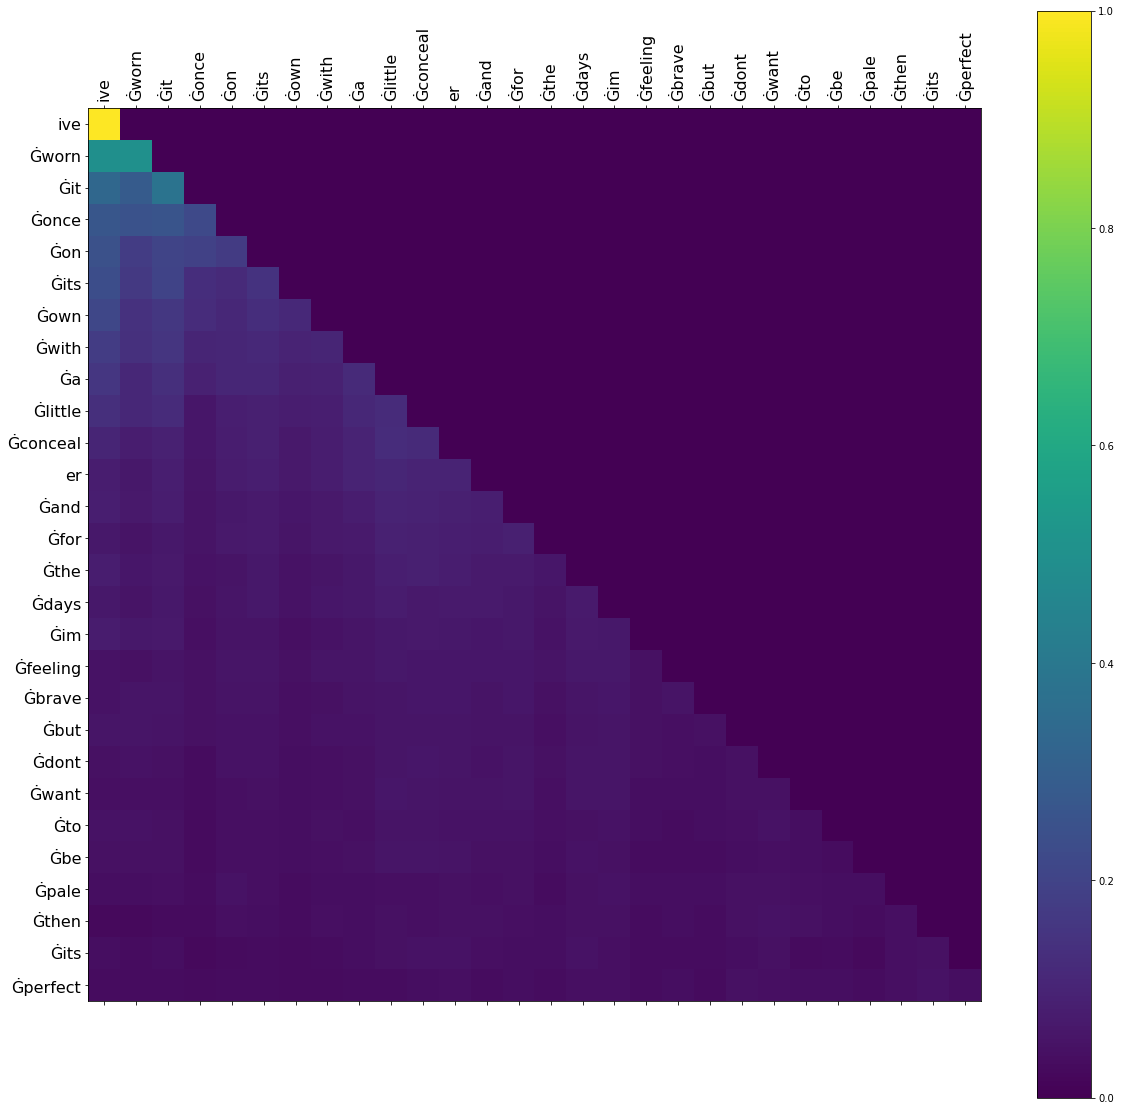

In [39]:
attns = get_attention_matrixes(model_0, tokenizer, text)
show_attention(tokens, attns[-1][0])

как видим аттеншн размазан по словам, модель не успела еще аккумулировать информацию о связях в словах

попробуем поменять оптимизатор и добавить lr scheduler из пакета transformers, предполагаем, что модель сойдется за меньшее количество эпох чем предыдущая

In [42]:
from transformers import AdamW, get_linear_schedule_with_warmup


model_0 = GPT2ForSequenceClassification(config=config).to(device) # GPT2 для классификации текста
criterion = nn.CrossEntropyLoss() # в принципе лишнее, внутри GPT2ForSequenceClassification уже он есть
optimizer = AdamW(model_0.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                  )

num_epochs = 5
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)




for e in range(num_epochs):
    gc.collect()
    torch.cuda.empty_cache()
    model_0.train()
    train_loss, train_acc = 0, 0
    for batch in tqdm(train_loader):
        targets = batch['target'].to(device)
        input_ids = batch['input_ids'].squeeze(1).to(device)
        attention_mask  = batch['mask'].squeeze(1).to(device)
        optimizer.zero_grad()
        outputs = model_0(input_ids=input_ids,attention_mask=attention_mask,labels=targets)
        loss, outputs = outputs["loss"], outputs["logits"]
        train_loss += criterion(outputs,targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_acc += accuracy_(outputs,targets).item() 
    
    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Train Acc: {train_acc / len(train_loader)}")
    
    
    valid_loss = 0
    valid_acc = 0
    model_0.eval()
    with torch.no_grad():
        for batch in valid_loader:
            targets = batch['target'].to(device)
            input_ids = batch['input_ids'].squeeze(1).to(device)
            attention_mask  = batch['mask'].squeeze(1).to(device)
            outputs = model_0(input_ids=input_ids,attention_mask=attention_mask,labels=targets)
            loss, outputs = outputs["loss"], outputs["logits"]
            valid_loss += loss
            valid_acc += accuracy_(outputs,targets).item() 

    print(f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Valid Acc: {valid_acc / len(valid_loader)}")
    
test_acc = 0
model_0.eval()
with torch.no_grad():
    for batch in test_loader:
        targets = batch['target'].to(device)
        input_ids = batch['input_ids'].squeeze(1).to(device)
        attention_mask  = batch['mask'].squeeze(1).to(device)
        outputs = model_0(input_ids=input_ids,attention_mask=attention_mask,labels=targets)
        outputs, loss = outputs["logits"], outputs["loss"]
        test_acc += accuracy_(outputs,targets).item()
print(f"Test Acc: {test_acc / len(test_loader)}")


Train Loss: 1.5341124534606934,Train Acc: 0.382875
Valid Loss: 1.2914434671401978,Valid Acc: 0.515625



Train Loss: 1.0631866455078125,Train Acc: 0.60775
Valid Loss: 0.8430473208427429,Valid Acc: 0.6962890625



Train Loss: 0.6673798561096191,Train Acc: 0.760375
Valid Loss: 0.7130217552185059,Valid Acc: 0.7490234375



Train Loss: 0.4850963354110718,Train Acc: 0.824875
Valid Loss: 0.6072957515716553,Valid Acc: 0.78515625



Train Loss: 0.386447012424469,Train Acc: 0.858625
Valid Loss: 0.5700544118881226,Valid Acc: 0.80078125
Test Acc: 0.79931640625


как мы и ожидали, получили тот же результат, но процесс тренировки более гладкий (эпох можно было выбрать 4, на 5 уже оверфитится)

## Fine-tuning

Теперь другой подход: загрузим модель, которая обучалась решать задачу Language Modeling. Посмотрим, получим ли мы прирост в качестве.

In [7]:
model_1 = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2", 
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=8
).to(device)

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
from transformers import AdamW, get_linear_schedule_with_warmup
# lr = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)

criterion = nn.CrossEntropyLoss() # в принципе лишнее, внутри GPT2ForSequenceClassification уже он есть
optimizer = AdamW(model_1.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                  )

num_epochs = 10
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Вывод модели ничем не отличается от предыдущего случая, поэтому сразу приступаем к обучению:

In [17]:
from tqdm.notebook import tqdm


# Train loop
for e in range(num_epochs):
    model_1.train()
    train_acc, train_loss = 0, 0
    for batch in tqdm(train_loader):
        targets = batch['target'].to(device)
        input_ids = batch['input_ids'].squeeze(1).to(device)
        attention_mask  = batch['mask'].squeeze(1).to(device)
        optimizer.zero_grad()
        outputs = model_1(input_ids=input_ids,attention_mask=attention_mask,labels=targets)
        loss, outputs = outputs["loss"], outputs["logits"]
        train_loss += criterion(outputs,targets)
        # loss = criterion(outputs,targets) # GPT уже посчитал loss
        loss.backward()
        optimizer.step()
        # scheduler.step()
        train_acc += accuracy_(outputs,targets).item() 

    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Train Acc: {train_acc / len(train_loader)}")
    
        
    valid_loss = 0
    valid_acc = 0
    model_1.eval()
    with torch.no_grad():
        for batch in valid_loader:
            targets = batch['target'].to(device)
            input_ids = batch['input_ids'].squeeze(1).to(device)
            attention_mask  = batch['mask'].squeeze(1).to(device)
            outputs = model_1(input_ids=input_ids,attention_mask=attention_mask,labels=targets)
            loss, outputs = outputs["loss"], outputs["logits"]
            valid_loss += loss #criterion(outputs, targets)
            valid_acc += accuracy_(outputs,targets).item() 


    print(f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Valid Acc: {valid_acc / len(valid_loader)}")


Train Loss: 1.1943610906600952,Train Acc: 0.5484375
Valid Loss: 0.40560463070869446,Valid Acc: 0.86376953125



Train Loss: 0.3173421025276184,Train Acc: 0.8885625
Valid Loss: 0.19514448940753937,Valid Acc: 0.92529296875



Train Loss: 0.18844422698020935,Train Acc: 0.9259375
Valid Loss: 0.16281349956989288,Valid Acc: 0.9296875



Train Loss: 0.15139862895011902,Train Acc: 0.9348125
Valid Loss: 0.14302195608615875,Valid Acc: 0.9365234375



Train Loss: 0.13227221369743347,Train Acc: 0.9401875
Valid Loss: 0.14037731289863586,Valid Acc: 0.9326171875



Train Loss: 0.11659946292638779,Train Acc: 0.9463125
Valid Loss: 0.12534888088703156,Valid Acc: 0.93505859375



Train Loss: 0.10602661222219467,Train Acc: 0.949125
Valid Loss: 0.13771572709083557,Valid Acc: 0.9345703125



Train Loss: 0.09888351708650589,Train Acc: 0.9531875
Valid Loss: 0.13841401040554047,Valid Acc: 0.935546875



Train Loss: 0.0925389975309372,Train Acc: 0.9533125
Valid Loss: 0.1370541751384735,Valid Acc: 0.93701171875



Train Loss: 0.08498038351535797,Train Acc: 0.9593125
Valid Loss: 0.1367630958557129,Valid Acc: 0.9384765625


In [18]:
test_acc = 0
model_1.eval()
with torch.no_grad():
    for batch in test_loader:
        targets = batch['target'].to(device)
        input_ids = batch['input_ids'].squeeze(1).to(device)
        attention_mask  = batch['mask'].squeeze(1).to(device)
        outputs = model_1(input_ids=input_ids,attention_mask=attention_mask,labels=targets)
        loss, outputs = outputs["loss"], outputs["logits"]
        test_acc += accuracy_(outputs,targets).item()

print(f"Test Acc: {test_acc / len(test_loader)}")

Test Acc: 0.92626953125


Есть ли прирост качества или скорости обучения?

Посмотри на карты внимания. Есть ли отличие от предыдущего случая?

да, конечно, прирост значителен, карты внимания думаю также изменились

In [19]:
text = emotion_dataset['train']['text'][42] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

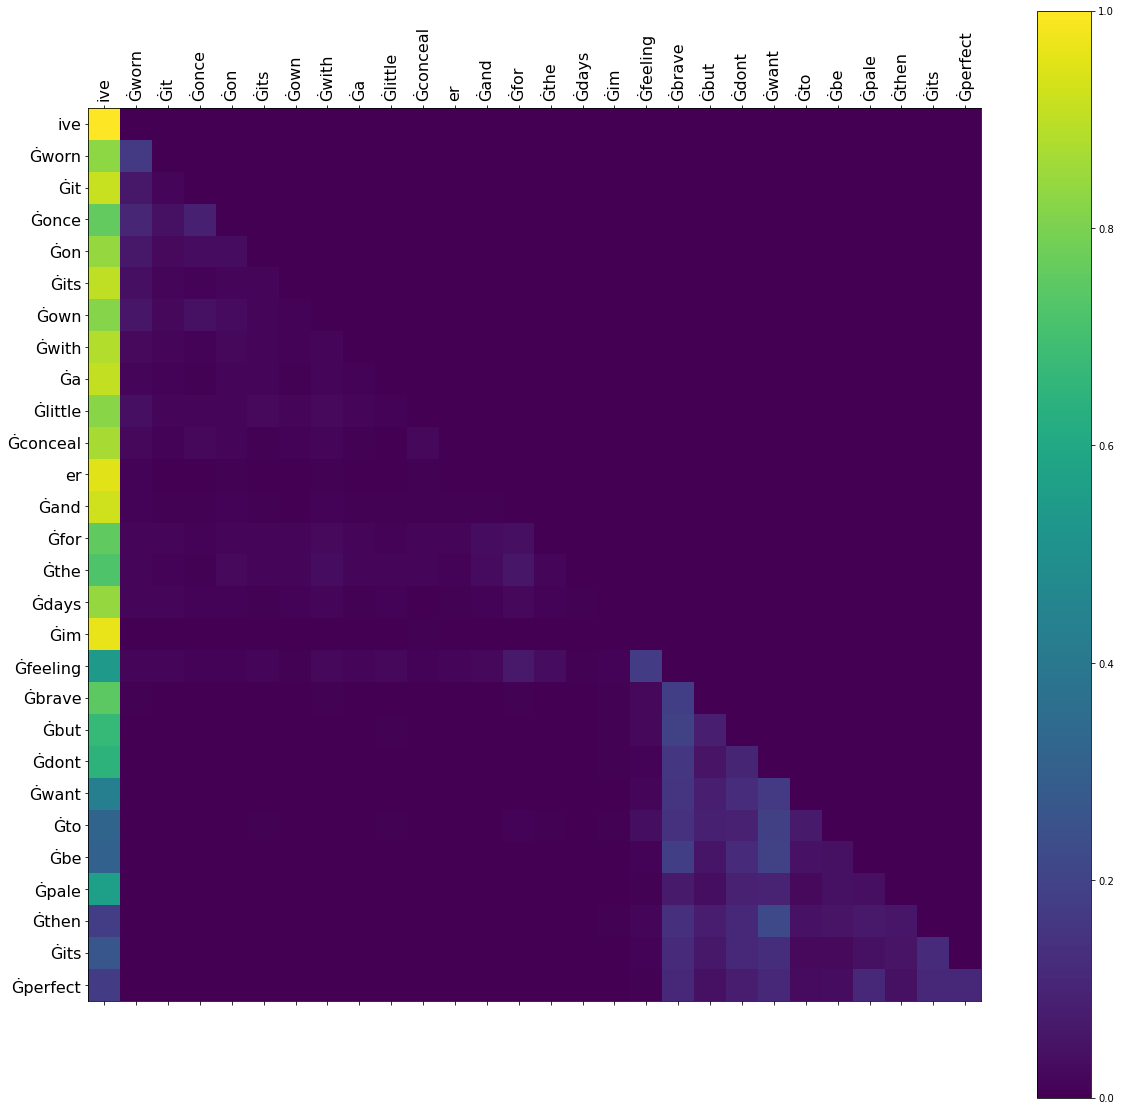

In [22]:
attns = get_attention_matrixes(model_1, tokenizer, text)
show_attention(tokens, attns[-1][0])

карты внимания показывают, эта модель уже имеет некоторое "представление" о языке и связывает слова находящиеся необязательно рядом

## Отчет

Покажи здесь, что ты выполнил по этой работе. Ответь на несколько вопросов:
- Какой подход оказался лучше? 
- На какие слова модель большего всего обращала внимание?
- На каких слоях/головах модель обращала внимание?

< твой отчет/ответы >

Модель с предъобученными весами безусловно лучше в сравнении с обычной по метрикам качества.

<div id="markdownResult" style="background-color: rgb(255, 255, 255); margin: auto; width: 290px;"><table><tbody><tr><th align="center"></th><th align="center"><b>vanilla model</b></th><th align="center"><b>pretrained model</b></th></tr><tr><td align="center">Test Acc:</td><td align="center">0.79</td><td align="center">0.92</td></tr>
</tbody></table></div>

обычная модель больше обращает внимание все же на соседние слова, в то время как предобученная уже имеет некоторое "представление" о языке и связывает слова находящиеся необязательно рядом